In [2]:
!pip install yfinance

In [6]:
!pip install arch

   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
    -------------------------------------- 20.5/926.2 kB 330.3 kB/s eta 0:00:03
   - ------------------------------------- 41.0/926.2 kB 495.5 kB/s eta 0:00:02
   ----- ---------------------------------- 133.1/926.2 kB 1.1 MB/s eta 0:00:01
   -------------------- ------------------- 481.3/926.2 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 926.2/926.2 kB 4.9 MB/s eta 0:00:00


In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="arch.univariate.base")

ticker = 'MSFT'
start_date = '2020-01-01'
end_date = '2025-07-01'

print(f"Attempting to download data for {ticker} from {start_date} to {end_date}...")
try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}. Please check the ticker symbol or date range.")
    print(f"Successfully downloaded {len(data)} data points for {ticker}.")
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()


C:\Users\achin\AppData\Local\Temp\ipykernel_24156\50509121.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Attempting to download data for MSFT from 2020-01-01 to 2025-07-01...
Successfully downloaded 1380 data points for MSFT.


In [24]:

data['Close'].fillna(method='ffill', inplace=True) # Forward fill any missing adjusted close prices
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
returns = data['log_return'].dropna() * 100 # Multiply by 100 for percentage returns

data['simple_return'] = data['Close'].pct_change()
# Calculate cumulative returns
data['cumulative_returns'] = (1 + data['simple_return']).cumprod() - 1
data['cumulative_returns'].iloc[0] = 0 # Set the first cumulative return to 0 or initial price


C:\Users\achin\AppData\Local\Temp\ipykernel_24156\2806912861.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'].fillna(method='ffill', inplace=True) # Forward fill any missing adjusted close prices
C:\Users\achin\AppData\Local\Temp\ipykernel_24156\2806912861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'].fillna(method='ffill', inplace=True) # Forward fill any missing adjusted close prices
C:\Users\achin\AppData\Local\Temp\ipykernel_24156\2806912861.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default be

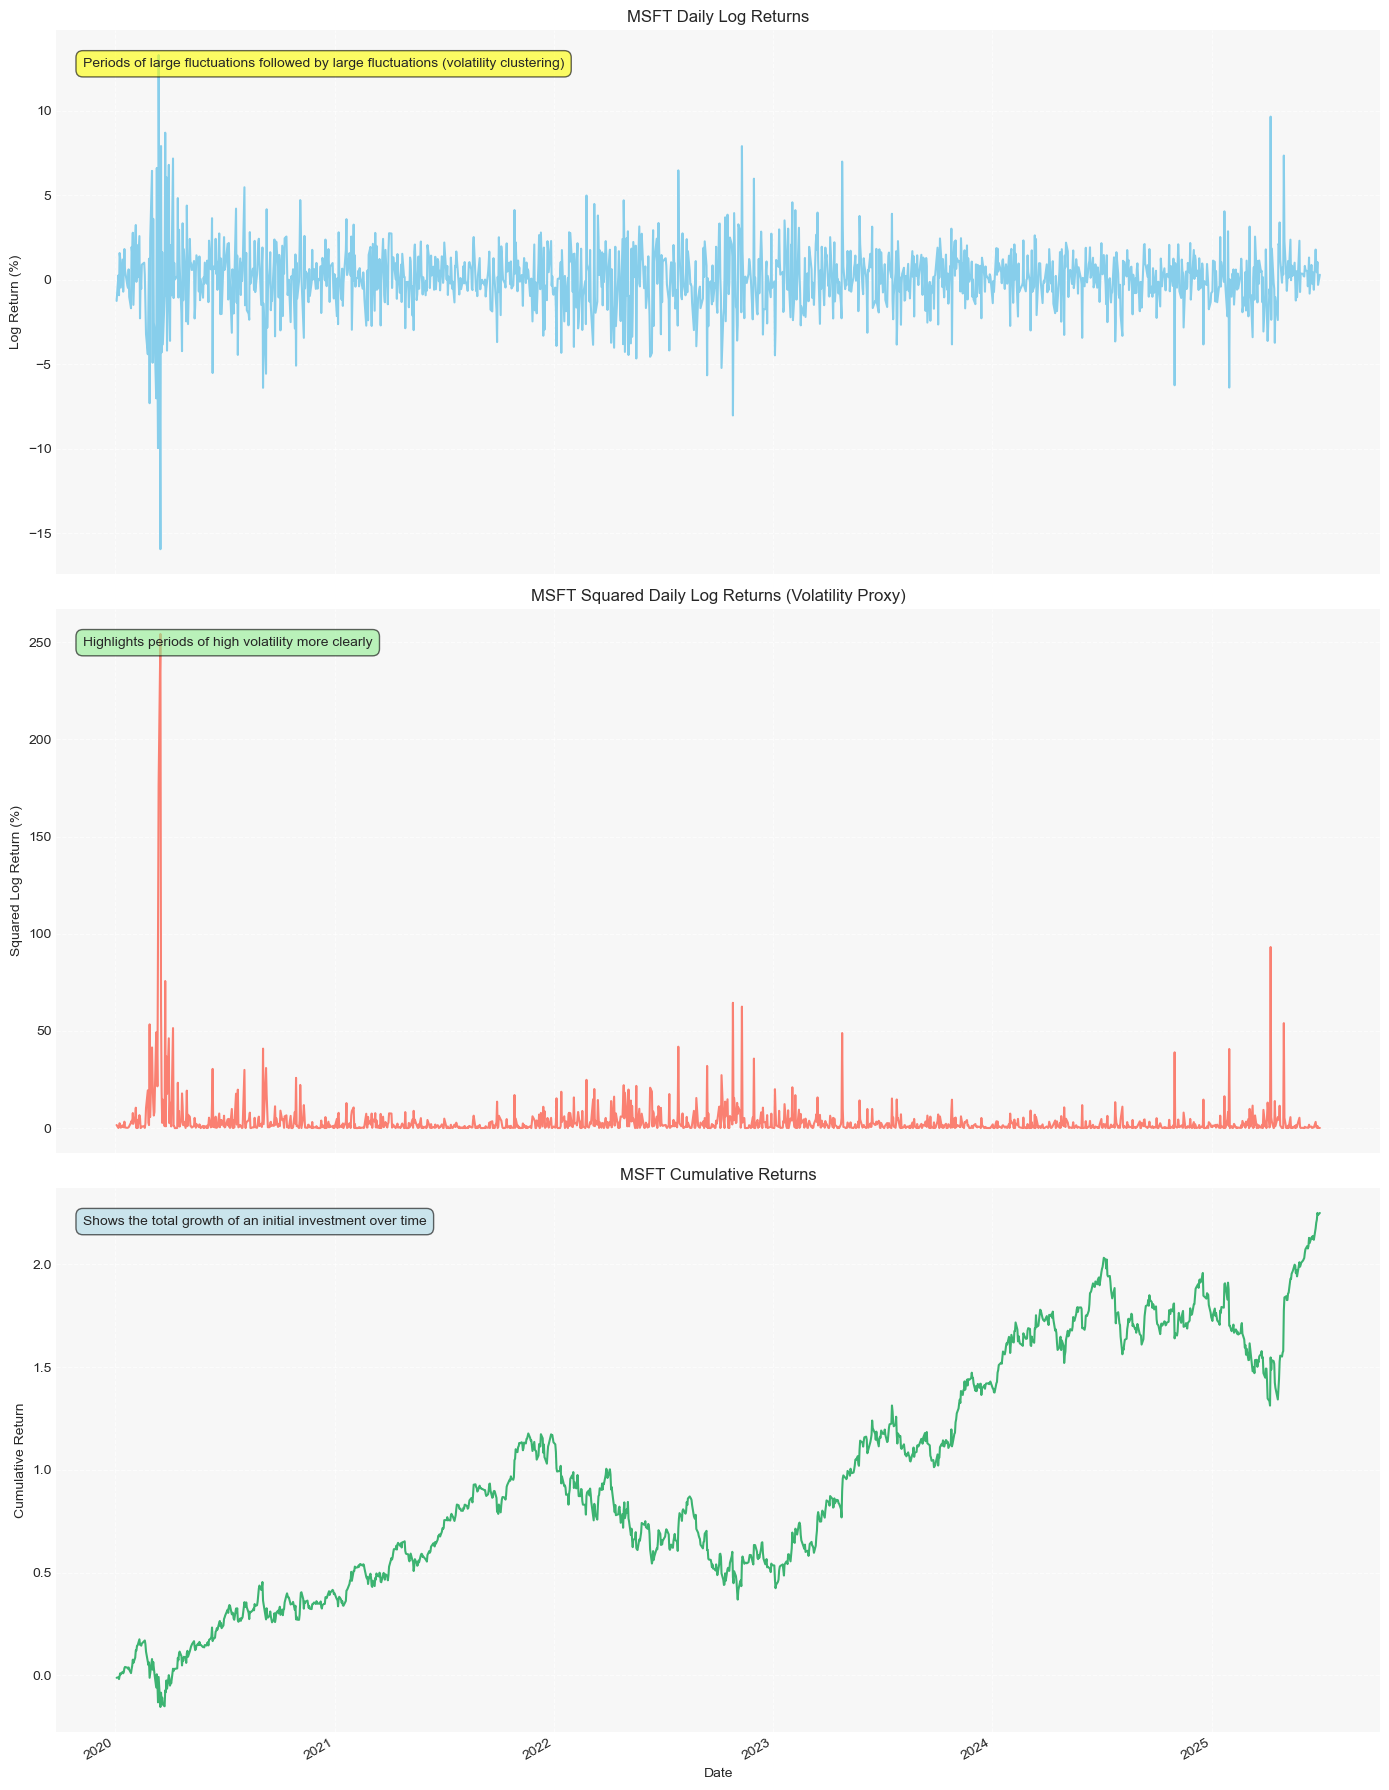


--- Volatility Clustering and Return Visualization ---
The plots above illustrate volatility clustering, a common phenomenon in financial time series where large changes tend to be followed by large changes, and small changes by small changes.
The squared returns plot amplifies these periods of high and low volatility.
Cumulative returns show the total return an investor would have received if they held the stock from the start date, reinvesting any hypothetical dividends (as adjusted close prices account for this).


In [ ]:

plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot Daily Log Returns
returns.plot(ax=axes[0], title=f'{ticker} Daily Log Returns', color='skyblue')
axes[0].set_ylabel('Log Return (%)')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_facecolor('#f7f7f7')
axes[0].text(0.02, 0.95, "Periods of large fluctuations followed by large fluctuations (volatility clustering)",
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.6))

# Plot Squared Daily Log Returns (Proxy for Volatility)
(returns**2).plot(ax=axes[1], title=f'{ticker} Squared Daily Log Returns (Volatility Proxy)', color='salmon')
axes[1].set_ylabel('Squared Log Return (%)')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_facecolor('#f7f7f7')
axes[1].text(0.02, 0.95, "Highlights periods of high volatility more clearly",
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.6))


# Plot Cumulative Returns
data['cumulative_returns'].plot(ax=axes[2], title=f'{ticker} Cumulative Returns', color='mediumseagreen')
axes[2].set_ylabel('Cumulative Return')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_facecolor('#f7f7f7')
axes[2].text(0.02, 0.95, "Shows the total growth of an initial investment over time",
             transform=axes[2].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.6))


plt.xlabel('Date')
plt.tight_layout()
plt.show()

print("\n--- Volatility Clustering and Return Visualization ---")
print("The plots above illustrate volatility clustering, a common phenomenon in financial time series where large changes tend to be followed by large changes, and small changes by small changes.")
print("The squared returns plot amplifies these periods of high and low volatility.")
print("Cumulative returns show the total return an investor would have received if they held the stock from the start date, reinvesting any hypothetical dividends (as adjusted close prices account for this).")



--- Autocorrelation of Returns and Squared Returns ---
Examining autocorrelation helps determine if ARCH/GARCH effects are present.


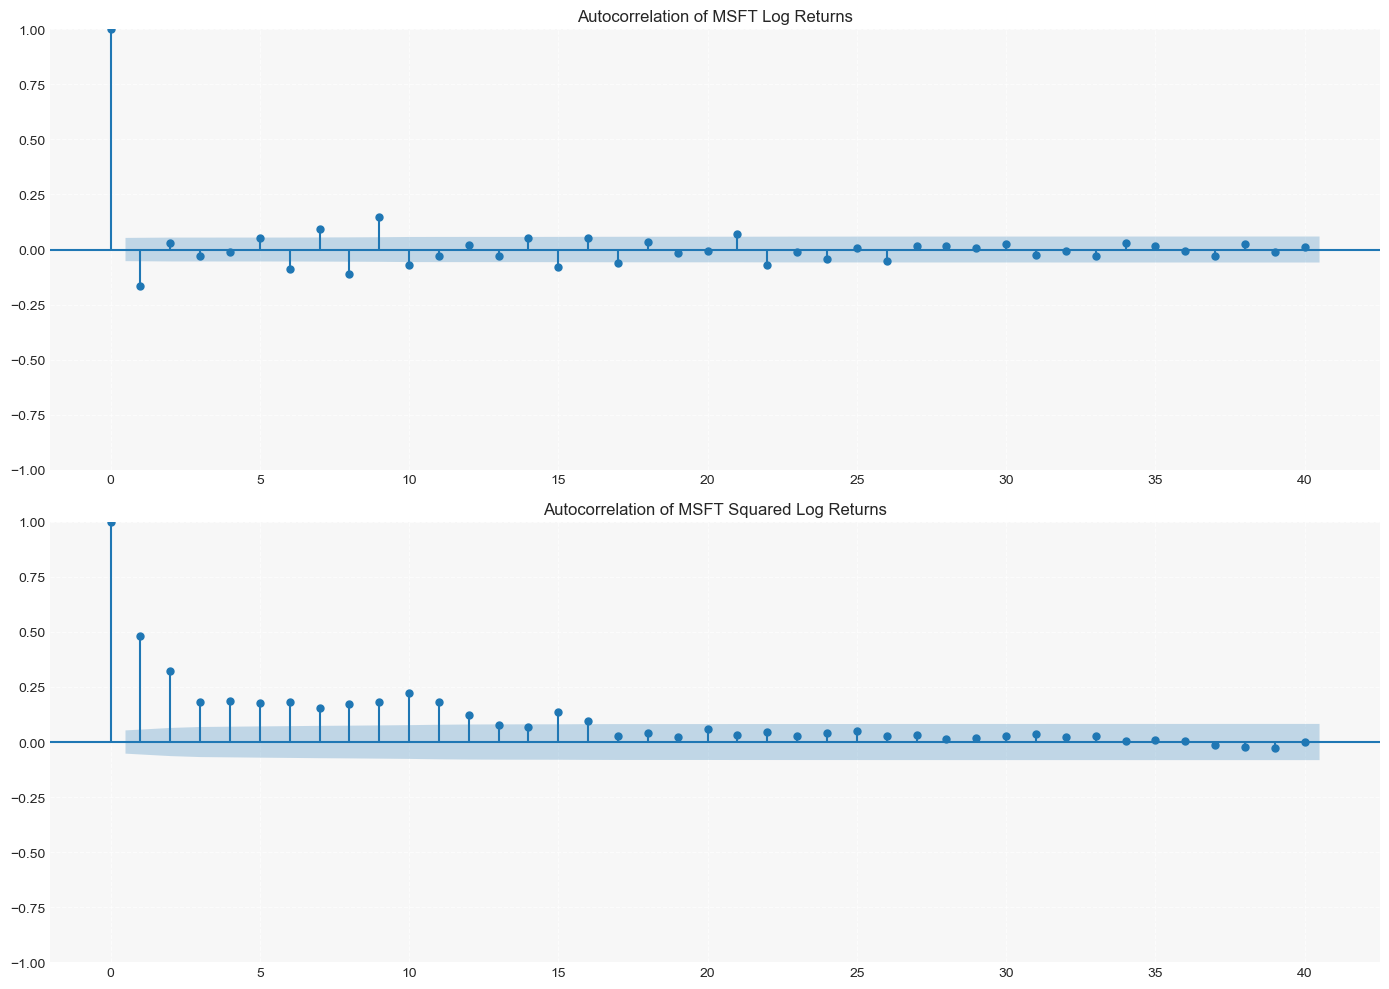

Significant autocorrelation in squared returns (even if little in raw returns) suggests that a GARCH model is appropriate.
This indicates that past volatility influences current volatility.


In [ ]:

print("\n--- Autocorrelation of Returns and Squared Returns ---")
print("Examining autocorrelation helps determine if ARCH/GARCH effects are present.")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(returns, lags=40, ax=axes[0], title=f'Autocorrelation of {ticker} Log Returns')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_facecolor('#f7f7f7')

plot_acf(returns**2, lags=40, ax=axes[1], title=f'Autocorrelation of {ticker} Squared Log Returns')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_facecolor('#f7f7f7')

plt.tight_layout()
plt.show()

print("Significant autocorrelation in squared returns (even if little in raw returns) suggests that a GARCH model is appropriate.")
print("This indicates that past volatility influences current volatility.")



In [ ]:

print("\n--- Fitting GARCH(1,1) Model ---")
model = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')

# Fit the model
results = model.fit(update_freq=5, disp='off')

# Print the model summary
print(results.summary())

print("\n--- Interpreting GARCH Model Summary ---")
print("Key parameters to look at in the summary:")
print("1.  **omega (ω):** The constant term in the conditional variance equation. It represents the baseline level of volatility.")
print("2.  **alpha[1] (α):** The coefficient for the lagged squared residual (ARCH term). A significant positive α indicates that past 'shocks' (large returns, positive or negative) have an impact on current volatility.")
print("3.  **beta[1] (β):** The coefficient for the lagged conditional variance (GARCH term). A significant positive β indicates that past volatility itself influences current volatility, demonstrating persistence in volatility.")
print("4.  **Sum of alpha and beta (α + β):** If (α + β) is close to 1, it suggests high persistence of volatility, meaning shocks to volatility take a long time to decay. If it's greater than 1, the process might not be stationary.")
print("5.  **Log-Likelihood:** Used for model comparison (higher is better for different models on the same data).")
print("6.  **P-values:** For each coefficient, a p-value less than 0.05 (or your chosen significance level) indicates statistical significance.")




--- Fitting GARCH(1,1) Model ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2695.14
Distribution:                  Normal   AIC:                           5398.28
Method:            Maximum Likelihood   BIC:                           5419.20
                                        No. Observations:                 1379
Date:                Wed, Jul 09 2025   Df Residuals:                     1378
Time:                        12:57:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1099  4.608e-

In [ ]:

print("\n--- Volatility Forecast ---")
# Forecast the next 5 days of volatility
forecasts = results.forecast(horizon=5, method='analytic')

# The forecast object contains the mean and variance forecasts
# We are interested in the variance, so we will take the square root to get the standard deviation (volatility)
# The .iloc[-1] selects the last row of the variance dataframe, which corresponds to the last available forecast start point.
forecast_variance = forecasts.variance.iloc[-1]
forecast_volatility = np.sqrt(forecast_variance)

print("\nForecasted annualized volatility for the next 5 days (in %):")
# Annualize daily volatility: Daily Volatility * sqrt(252 trading days)
# Remember our returns are already multiplied by 100, so the GARCH output for conditional volatility is also in %
annualized_forecast_volatility = forecast_volatility * np.sqrt(252)
print(annualized_forecast_volatility)




--- Volatility Forecast ---

Forecasted annualized volatility for the next 5 days (in %):
h.1    18.820694
h.2    19.420926
h.3    19.977452
h.4    20.494954
h.5    20.977369
Name: 2025-06-30 00:00:00, dtype: float64


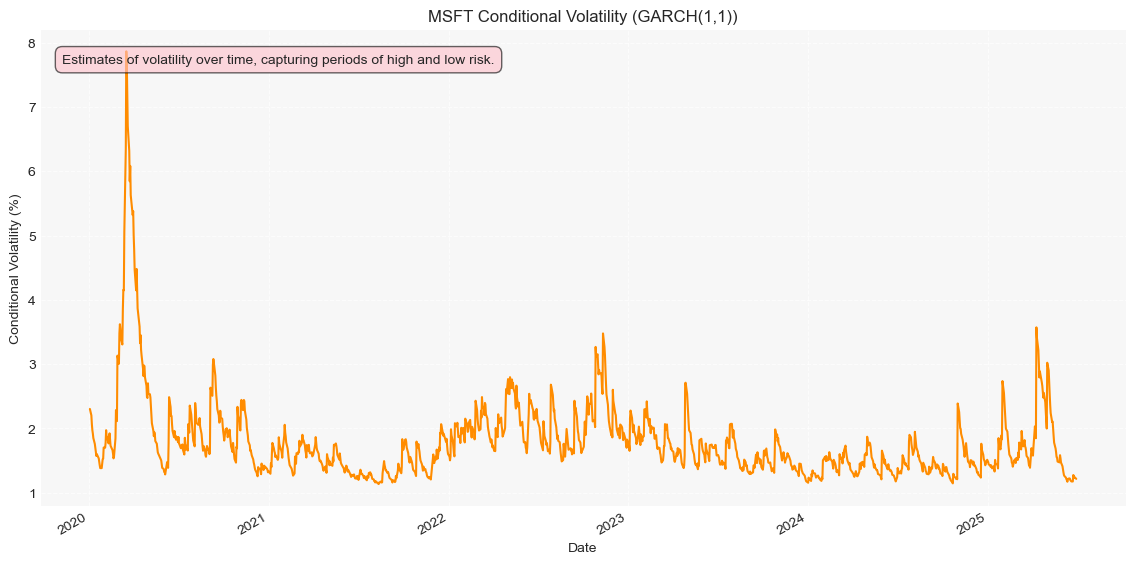


--- Conditional Volatility Visualization ---
The plot of conditional volatility shows the GARCH model's estimate of the asset's volatility at each point in time.
This series often mirrors the periods of high and low squared returns, but provides a smoothed, more refined estimate of future volatility based on the model's parameters.


In [ ]:

plt.figure(figsize=(14, 7))
results.conditional_volatility.plot(title=f'{ticker} Conditional Volatility (GARCH(1,1))', color='darkorange')
plt.ylabel('Conditional Volatility (%)')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.text(0.02, 0.95, "Estimates of volatility over time, capturing periods of high and low risk.",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.6))
plt.show()

print("\n--- Conditional Volatility Visualization ---")
print("The plot of conditional volatility shows the GARCH model's estimate of the asset's volatility at each point in time.")
print("This series often mirrors the periods of high and low squared returns, but provides a smoothed, more refined estimate of future volatility based on the model's parameters.")



--- GARCH Model Diagnostics ---


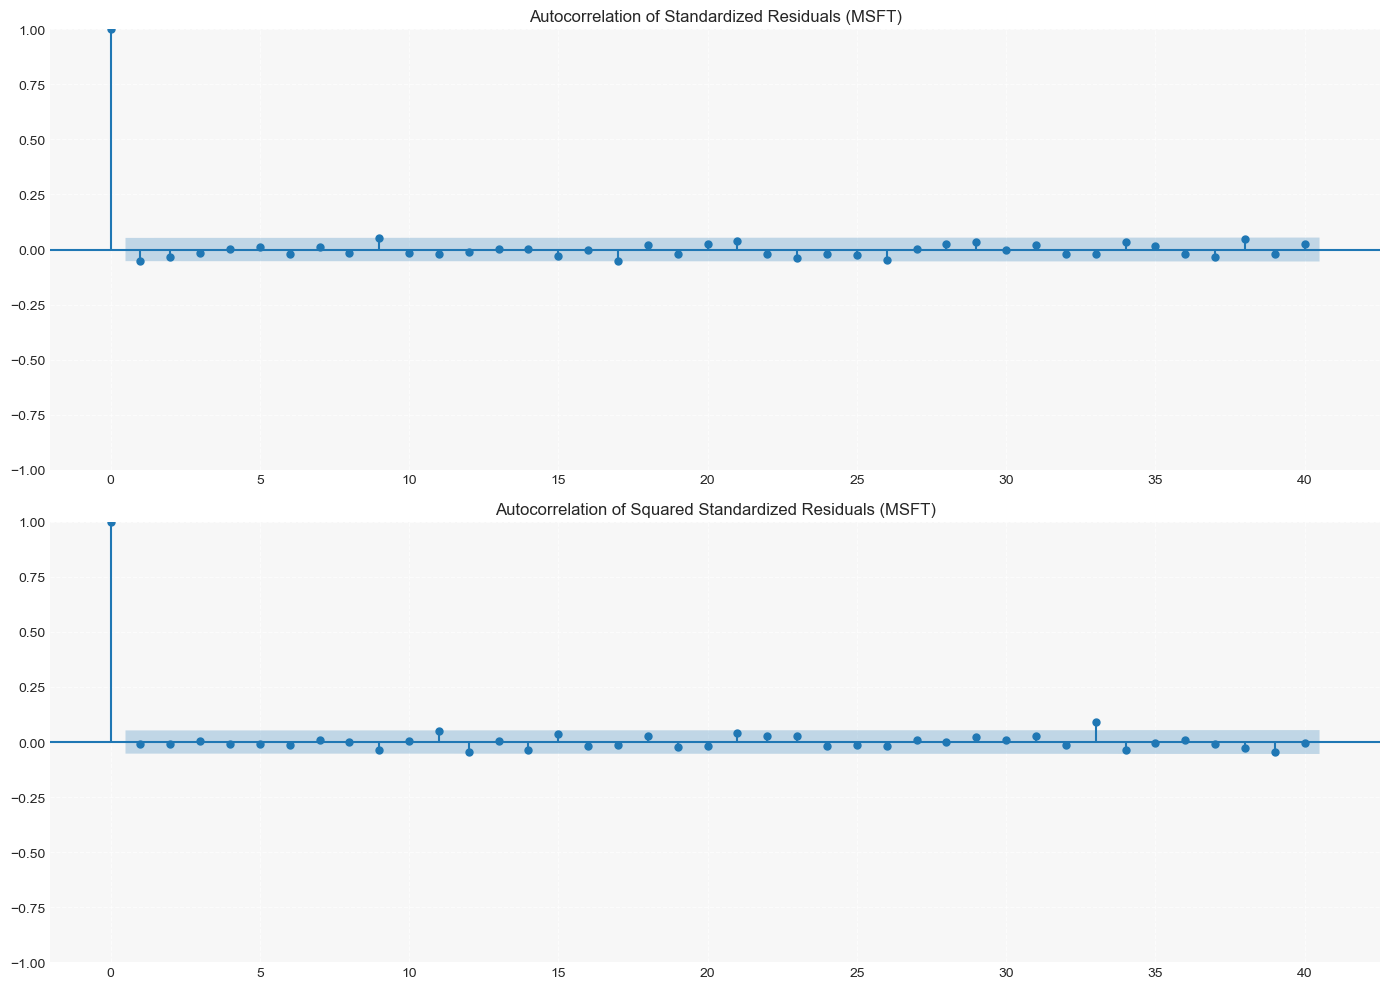

If the GARCH model is well-specified, the standardized residuals and their squares should show little to no significant autocorrelation.
Any significant spikes indicate that there might be remaining volatility patterns not captured by the model, suggesting a need for a different GARCH order (p,q) or a more complex model (e.g., EGARCH for asymmetric effects).

--- Conclusion and Next Steps ---
This script demonstrates a comprehensive workflow for GARCH modeling in financial time series, from data fetching and visualization to model fitting, forecasting, and diagnostics.
For practical applications, consider:
 - **Alternative GARCH models:** EGARCH, TGARCH for asymmetric volatility responses (leverage effect).
 - **Different error distributions:** Student's t, Skewed Student's t for heavy-tailed or skewed returns.
 - **Backtesting:** Evaluate forecast accuracy over out-of-sample periods.
 - **Rolling forecasts:** Continuously update forecasts as new data becomes available.


In [ ]:

print("\n--- GARCH Model Diagnostics ---")
# Standardized residuals should ideally be uncorrelated and have a mean of 0 and variance of 1.
# Their squares should also be uncorrelated.
standardized_residuals = results.resid / results.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(standardized_residuals, lags=40, ax=axes[0], title=f'Autocorrelation of Standardized Residuals ({ticker})')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_facecolor('#f7f7f7')

plot_acf(standardized_residuals**2, lags=40, ax=axes[1], title=f'Autocorrelation of Squared Standardized Residuals ({ticker})')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_facecolor('#f7f7f7')

plt.tight_layout()
plt.show()

print("If the GARCH model is well-specified, the standardized residuals and their squares should show little to no significant autocorrelation.")
print("Any significant spikes indicate that there might be remaining volatility patterns not captured by the model, suggesting a need for a different GARCH order (p,q) or a more complex model (e.g., EGARCH for asymmetric effects).")


print("\n--- Conclusion and Next Steps ---")
print("This script demonstrates a comprehensive workflow for GARCH modeling in financial time series, from data fetching and visualization to model fitting, forecasting, and diagnostics.")
print("For practical applications, consider:")
print(" - **Alternative GARCH models:** EGARCH, TGARCH for asymmetric volatility responses (leverage effect).")
print(" - **Different error distributions:** Student's t, Skewed Student's t for heavy-tailed or skewed returns.")
print(" - **Backtesting:** Evaluate forecast accuracy over out-of-sample periods.")
print(" - **Rolling forecasts:** Continuously update forecasts as new data becomes available.")